In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as njit
import scipy as sp
import time

# 8) Interpolation, Win a PRIZE at the end
Instructions
- Trace the movement of electrons in the electromagnetic potential from the last exercise with an integrator (Leapfrog, RK4). Use bilinear interpolation for the potential.
- The domain has the size of 0.01m in both dimensions, the electrons start at x=0 and y=0.007...0.009. The detector is at x=0.01 and y=0.001...0.003.
- Create a plot showing the paths of the electrons in the potential.
- Create histograms showing the arrival time and arrival position distribution.
- Use bicubic interpolation and check if this makes any difference.
- Then, use this to design an optimal electron detector. 
Optimize the detector design such that the most electrons hit the detector and the scatter in flight time is the smallest.

### First Part of the code
In this first part of the code, I will define the classes used in the code.

In [2]:
class Electron:
    def __init__(self, initial_position, initial_velocity):
        self.mass = 9.11 * 10**(-31) # kg
        self.charge = -1.6 * 10**(-19) # Coulomb
        self.positions = [np.array(initial_position)]
        self.velocities = [np.array(initial_velocity)]

        # alive means, that the electron is still in the grid
        self.alive = True 

        # here we will add all the time steps this electron takes
        self.time_alive = 0

    def get_x_positions(self):
        return [pos[0] for pos in self.positions]

    def get_y_positions(self):
        return [pos[1] for pos in self.positions]

In [3]:
class VoltageGrid:
    def __init__(self, size=25, width=0.001, voltage=1000, w_value=1.6735835835835835):
        self.size = size # number of points in the square
        self.width = width # physical dimension of the box
        self.voltage = voltage # given voltage
        self.w_value = w_value # w values from the last exercise, to make the computation faster

        self.x = np.linspace(0, self.width, self.size)
        self.y = np.linspace(0, self.width, self.size)

        # sets up the grid
        self.setup_grid()

        # simulates the grid according to the exercise of last week
        self.simulate_grid()

        # interpolates the grid to get the gradient
        self.interpolate()

    """
    Setup of the grid, without simulating the distribution of the voltage
    """
    def setup_grid(self):

        # create the default grid with 0 at the edges and 1000 in the center
        basic_matrix = np.zeros((self.size, self.size))

        # define the points in the grid, where our voltage lies
        voltage_grid = np.zeros_like(basic_matrix, dtype=bool)

        voltage_grid[4:14, 49] = True
        #voltage_grid[34:44, 5] = True
        self.bresenham_line(voltage_grid, (38, 5), (8, 44))

        # define the bounds of our array
        bounds = np.zeros_like(basic_matrix, dtype=bool)
        bounds[0, :] = True
        bounds[-1, :] = True
        bounds[:, 0] = True
        bounds[:, -1] = True

        # define our update mask
        self.update_mask = np.ones_like(basic_matrix, dtype=bool)
        self.update_mask[voltage_grid] = False
        self.update_mask[bounds] = False

        # define our grid
        self.grid = np.zeros_like(basic_matrix)
        self.grid[voltage_grid] = self.voltage

    """
    Runs the simulation for the grid using sor and the checkerboard implementation, we used in the last exercise.
    The grid positions will then have the voltage value for when the change in values drops below the threshhold
    """
    def simulate_grid(self, threshhold=10**-3, max_iterations=1000000):

        # create the needed help components for this
        update_matrix = np.zeros_like(self.grid)
        diff_matrix = self.grid - update_matrix
        W = np.array([[0,1,0],[1,-4,1],[0,1,0]])

        # compute the checkerboard pattern
        checkerboard = np.indices((self.size, self.size)).sum(axis=0) % 2 == 0

        diff = 1 + threshhold
        current_iteration = 0

        while diff > threshhold and current_iteration <= max_iterations:

            # calculate the update for the first time
            sp.ndimage.convolve(self.grid, W, output=update_matrix, mode="constant", cval=0)
            update_matrix *= self.w_value / 4
            update_matrix[~self.update_mask] = 0 # exclue the bounds and the stick from the update

            # update our matrix
            self.grid[checkerboard] = self.grid[checkerboard] + update_matrix[checkerboard]

            # calculate the stuff the second time
            sp.ndimage.convolve(self.grid, W, output=update_matrix, mode="constant", cval=0)
            update_matrix *= self.w_value / 4
            update_matrix[~self.update_mask] = 0 # exclue the bounds and the stick from the update

            self.grid[~checkerboard] = self.grid[~checkerboard] + update_matrix[~checkerboard]

            diff = np.max(np.abs(update_matrix[self.update_mask]))
            current_iteration += 1

    """
    Using the calculated grid, this function does two things:
    1. It uses numpy.gradient to compute the gradient using the given point values across the grid
    2. Since our particle will be able to fall between the grid positions, we use scipy.interpolate.RegularGridInterpolator
    to get a function out of the calculated gradient points
    """
    def interpolate(self):
        self.grad_grid_y, self.grad_grid_x = np.gradient(self.grid, self.width / self.size)

        # because I want a function because our electron can also lie inbetween points so we need to interpolate these points
        # one could do this by hand -> but one can also enjoy life

        start = time.time()
        method = "linear"
        self.gradient_x = sp.interpolate.RegularGridInterpolator((self.x, self.y), self.grad_grid_x.T, method=method)
        self.gradient_y = sp.interpolate.RegularGridInterpolator((self.x, self.y), self.grad_grid_y.T, method=method)

        print(f"{method} took {time.time() - start} seconds")

    """
    uses the defined window, to see if the electron was detected by the machine before leaving the machine
    we simply check the last position of the electron, if we are out of bounds in the x direction and in the window in the y direction we "detect" the electron
    """
    def check_electron_detection(self, electron):
        x, y = electron.positions[-1]
        # basically the electorn has to be on the right hand side of the detector and in the detection window on the bottom
        return x >= self.width and 0.0001 <= y <= 0.0003

    """
    Given a position, this function will return the gradient corresponding to the position
    """
    def get_gradient(self, position):
        return np.array([self.gradient_x(position)[0], self.gradient_y(position)[0]])

    """
    Given the position, charge and mass of a particle, this function will return the acceleration on this particle
    the acceleration is calculated using the formula described in the lecture where
    acc = - (charge/mass) * gradient
    """
    def calculate_acceleration(self, position, charge, mass):
        return -1 * (charge / mass) * self.get_gradient(position)

    """
    Simply checks if the given position is in the grid
    """
    def is_position_in_grid(self, position):
        return (0 <= position[0] <= self.width) and (0 <= position[1] <= self.width)

    """
    Function used to vizualize the gradient using matplotlib
    """
    def visualize_gradient(self):
        ax.quiver(self.x, self.y, self.grad_grid_x, self.grad_grid_y, alpha=1)
    
    """
    Function used to visualize the grid using matplotlib
    """
    def visualize_grid(self):
        CPF = ax.contourf(self.x, self.y, self.grid, alpha=0.3)

    """
    Function used to calculate the positions of a line in the voltage grid
    -> Function is based on the code from wikipedia: https://de.wikipedia.org/wiki/Bresenham-Algorithmus
    -> but changes to fit my code and the implementation of the grid
    """
    def bresenham_line(self, voltage_grid, start, end):
        x0, y0 = start
        x1, y1 = end
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            voltage_grid[x0, y0] = True
            if (x0 == x1) and (y0 == y1):
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy


In [4]:
class ElectronSimulation():
    def __init__(self, grid, number_of_electrons, time_step=2 * 10**-12, width=0.01):
        self.grid = grid
        self.electron_velocity = 1e6
        self.electrons = []
        self.time_step = time_step
        self.width = width

        # generate the positions for the electrons
        # we basically put all electrons in the basic window in equal spacing from each other
        y = np.linspace(0.0007, 0.0009, number_of_electrons)

        # code for the velocity given in the lecture
        yv = np.random.uniform(-self.electron_velocity, self.electron_velocity, number_of_electrons)
        xv = np.sqrt(np.ones(1)*self.electron_velocity**2-yv**2) 

        for i in range(number_of_electrons):
            self.electrons.append(Electron(np.array([0, y[i]]), np.array([xv[i], yv[i]])))

    """
    This function calculates a single leapfrog step for any given electron,
    here we check the position of the particle twice to make sure, that it is still in the grid
    if not => the particle is set to dead (meaning out of bounds) and we stop calculating its position
    """
    def single_leapfrog_step(self, electron):

        # first drift step
        p_n_plus_half = electron.positions[-1] + self.time_step / 2 * electron.velocities[-1]

        # we need to validate, that the electron is still in the grid after this half step
        if(not self.grid.is_position_in_grid(p_n_plus_half)):
            # beeing here means the electron escaped the matrix somehow
            electron.alive = False
            electron.positions.append(p_n_plus_half) # since we want to store all positions of the electrons
            electron.time_alive += self.time_step / 2
            return np.array([0, 0]), np.array([0, 0])


        # kicks step
        acceleration = self.grid.calculate_acceleration(p_n_plus_half, electron.charge, electron.mass)
        v_n_plus_1 = electron.velocities[-1] + acceleration * self.time_step


        # second drift step
        p_n_plus_1 = p_n_plus_half + self.time_step/2 * v_n_plus_1

        if(not self.grid.is_position_in_grid(p_n_plus_1)):
            electron.alive = False

        electron.positions.append(p_n_plus_1)
        electron.velocities.append(v_n_plus_1)
        electron.time_alive += self.time_step

    """
    This function simulates the electron path from start to finish
    we do this for a single electron
    """
    def simulate_electron_path(self, electron, max_time_alive=3e-10):
        max_iterations = 1000 * max_time_alive / self.time_step
        current_iteration = 0
        while electron.alive and current_iteration <= max_iterations:
            # update the position of the electron
            self.single_leapfrog_step(electron)
            current_iteration += 1

    """
    We simulate the path for each of the electrons from start to finish: This is quite slow and depending on the
    -> grid this can take up to 5 minutes: What could we do better here?
    -> 1) Store all positions and velocities in a numpy array and then compute the acceleration for all of them at the same time
    -> 2) Use multithreading to simulate hundreds of electrons at the same time
    """
    def simulate_electrons(self):
        for e in self.electrons:
            self.simulate_electron_path(e)

### Second Part of the code
In this second part of the code, the simulation will be run and then evaluated

In [5]:
%%time

# run the simulation and do the analysis
size = 50
number_of_electrons = 10000

grid = VoltageGrid(size=size, voltage=1000)
electron_simulation = ElectronSimulation(grid, number_of_electrons)
electron_simulation.simulate_electrons()

detected_electrons = []
undetected_electrons = []
for e in electron_simulation.electrons:
    if(grid.check_electron_detection(e)):
        detected_electrons.append(e)
    else:
        undetected_electrons.append(e)

print(f"Detected: {(len(detected_electrons)*100 / number_of_electrons):.4f}%")
print(f"Undetected: {(len(undetected_electrons)*100 / number_of_electrons):.4f}%")
print(f"Unfinished: {(len([e for e in electron_simulation.electrons if e.alive])/number_of_electrons):.4f}%")
# Unfinished Electrons are the ones, that run out of time -> this is to reduce computation time
# I have tested this and can be quite sure, that the unfinished electrons would not have been detected anyway.

linear took 0.05645012855529785 seconds
Detected: 85.5500%
Undetected: 14.4500%
Unfinished: 0.0000%
CPU times: user 19.3 s, sys: 286 ms, total: 19.6 s
Wall time: 19.7 s


/var/folders/63/kr3r0_q93cs_34zrsvflw69r0000gn/T/ipykernel_10670/782831096.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


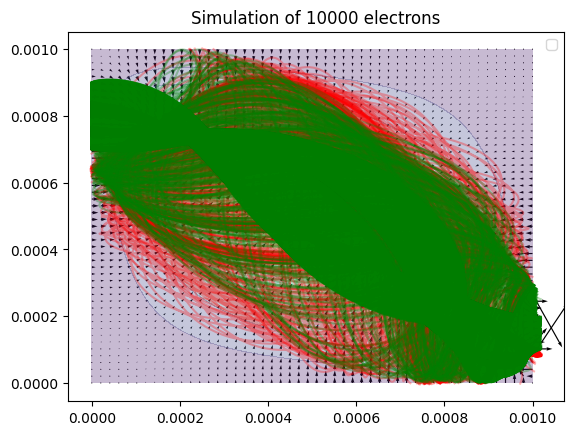

<Figure size 640x480 with 0 Axes>

In [6]:
fix, ax = plt.subplots()

# visualize the grid and the gradient
grid.visualize_gradient()
grid.visualize_grid()

# plot all the detected electrons in green and the undetected in red
for e in undetected_electrons: plt.plot(e.get_x_positions(), e.get_y_positions(), color='r', alpha=0.3)
for e in detected_electrons: plt.plot(e.get_x_positions(), e.get_y_positions(), color='g', alpha=0.3)

plt.title(f"Simulation of {number_of_electrons} electrons")
plt.legend()
plt.show()

# plot of the distribution of the arrival time
plt.clf()

### Create histograms showing the arrival time and arrival positions distribution

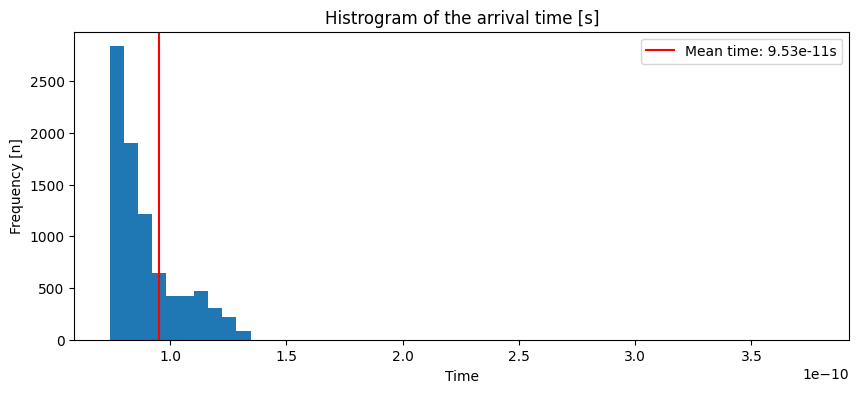

In [7]:
## Plotting of the arrival time -> of the electrons that 
times = []
for e in detected_electrons:
    times.append(e.time_alive)


# take the log of the values
#times = [np.log10(time) for time in times]
mean = np.mean(times)
std = np.std(times)

plt.figure(figsize=(10, 4))
new_times = [time for time in times if time <= 4e-10]
# Box Plot (log scale) 
plt.axvline(mean, color='red', label=f"Mean time: {mean:.2e}s")
plt.hist(new_times, bins=50)
plt.xlabel("Time")
plt.ylabel("Frequency [n]")
plt.title("Histrogram of the arrival time [s]")
plt.legend()
plt.show()


## We only show around the mean time, else we do not have any information, as the scattering is very big

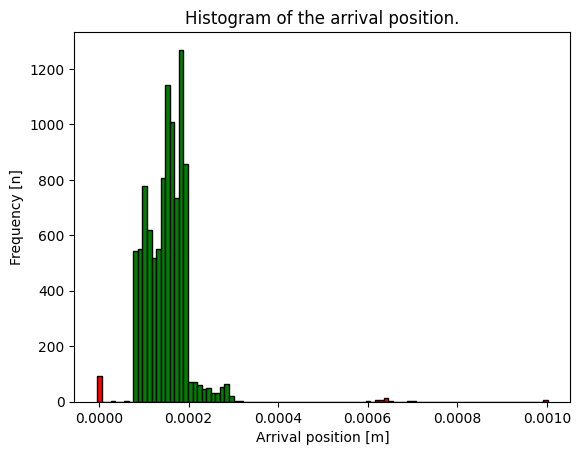

In [8]:
## Plotting the final positions
data = []
for e in electron_simulation.electrons:
    data.append(e.get_y_positions()[-1])


bins = np.linspace(min(data), max(data), 100) 

# Create histogram and plot
counts, bins, patches = plt.hist(data, bins=bins, edgecolor='black')

# Apply color conditions
for patch, value in zip(patches, bins):
    if 0.00001 <= value <= 0.0003:
        patch.set_facecolor('green')
    else:
        patch.set_facecolor('red')

plt.xlabel('Arrival position [m]')
plt.ylabel('Frequency [n]')
plt.title('Histogram of the arrival position.')
plt.show()

### Use bicubic interpolation and check if this makes any difference
Using linear interpolation, we get the following stats:
- Detected: 85.2400%
- Undetected: 14.7600%
- Unfinished: No unfinished electrons
- Computation time: 19.6 seconds
- Computation time (interpolation): 3.63-5 seconds

Using bicubic interpolation, we get the following stats:
- Detected: 85.3900%
- Undetected: 14.6100%
- Unfinishes: No unfinished electrons
- Computation time: 23.9 seconds
- Computation time (interpolation): 6.6-3 seconds

Since the bicupic interpolation uses not only the closest points of the grid to estimate the gradient, I was expecting this to be slower when generating the gradient. Which it is in this case. But we can see that the more time is lost when acutally simulating the electrons. But as I am going to explain later, this can not be based on the interpolation method as we use random y velocities.

Generally we would expect the bicubic interpolation to provide a smoother transition, which is important for the precision of the simulation. Here in thes case, I can neither confirm nor deny this assumption since we use a random generator for the velocities. If I would want to check this for real, I would need to run the code hundereds of times and then use the average combined with the standard deviation to check the assumption. For this to work, I would need to rewrite my entire code to run in much better time complexity, since I don't have all year to check this.
But I would guess, that since the statistics are very close to each other. In this example the linear interpolation is enough.